In [1]:
import os
print(os.getcwd())


c:\Users\alaud\OneDrive\Desktop\iitm-ds-lab-proj\CleanSpeech\src\tf-idf-logistic-reg


In [4]:
!pip install pandas


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\alaud\AppData\Local\Programs\Python\Python313\python.exe -m pip install --upgrade pip


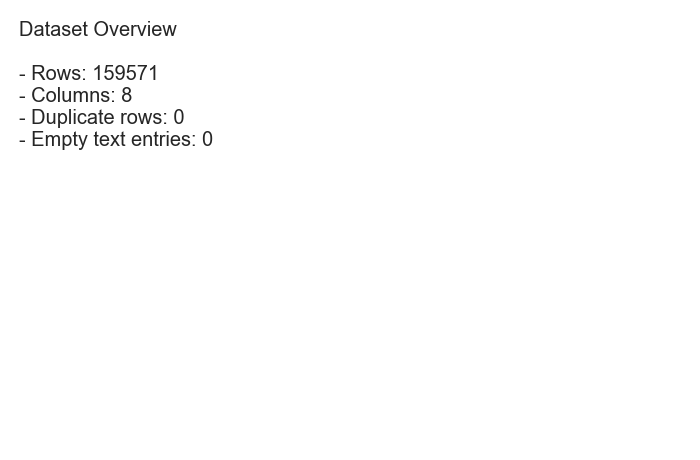

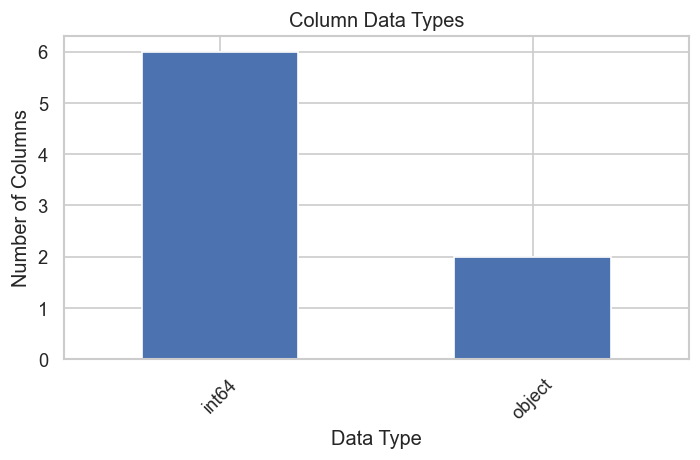

,column,dtype
0,id,object
1,comment_text,object
2,toxic,int64
3,severe_toxic,int64
4,obscene,int64
5,threat,int64
6,insult,int64
7,identity_hate,int64


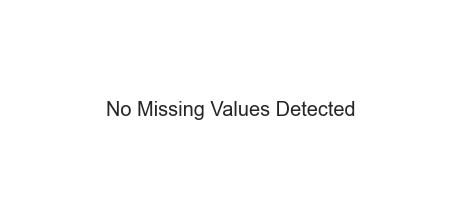

In [4]:
# 1. Data Inspection & Quality Check — VISUAL VERSION

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv("../data/train_data.csv")

sns.set(style="whitegrid")
plt.rcParams["figure.dpi"] = 120

# ========== A. Dataset overview (shape, duplicates, empty text) ==========
duplicate_count = df.duplicated().sum()
empty_text_count = df['comment_text'].apply(lambda x: str(x).strip() == '').sum()

fig, ax = plt.subplots(figsize=(6, 4))
ax.axis("off")

text = (
    f"Dataset Overview\n\n"
    f"- Rows: {df.shape[0]}\n"
    f"- Columns: {df.shape[1]}\n"
    f"- Duplicate rows: {duplicate_count}\n"
    f"- Empty text entries: {empty_text_count}"
)

ax.text(0.01, 0.98, text, va="top", ha="left", fontsize=12)
plt.tight_layout()
plt.show()

# ========== B. Column data types (visual summary) ==========
dtype_counts = df.dtypes.value_counts()

plt.figure(figsize=(6, 4))
dtype_counts.plot(kind="bar")
plt.title("Column Data Types")
plt.xlabel("Data Type")
plt.ylabel("Number of Columns")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Optional: show table of columns and dtypes (for slides)
dtype_table = pd.DataFrame({
    "column": df.columns,
    "dtype": df.dtypes.astype(str).values
})
display(dtype_table.style.set_caption("Columns and Data Types"))

# ========== C. Missing values per column ==========
missing_counts = df.isnull().sum()
missing_counts = missing_counts[missing_counts > 0].sort_values(ascending=False)

if not missing_counts.empty:
    plt.figure(figsize=(7, 4))
    missing_counts.plot(kind="bar")
    plt.title("Missing Values per Column")
    plt.xlabel("Column")
    plt.ylabel("Number of Missing Values")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()
else:
    fig, ax = plt.subplots(figsize=(4, 2))
    ax.axis("off")
    ax.text(0.5, 0.5, "No Missing Values Detected", ha="center", va="center", fontsize=12)
    plt.tight_layout()
    plt.show()


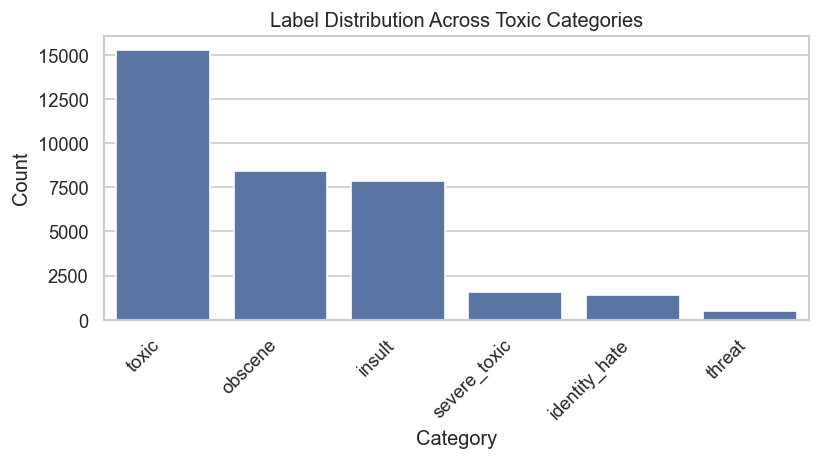

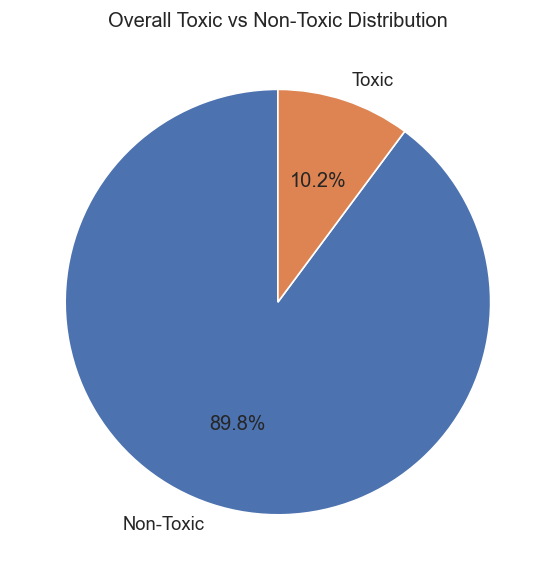

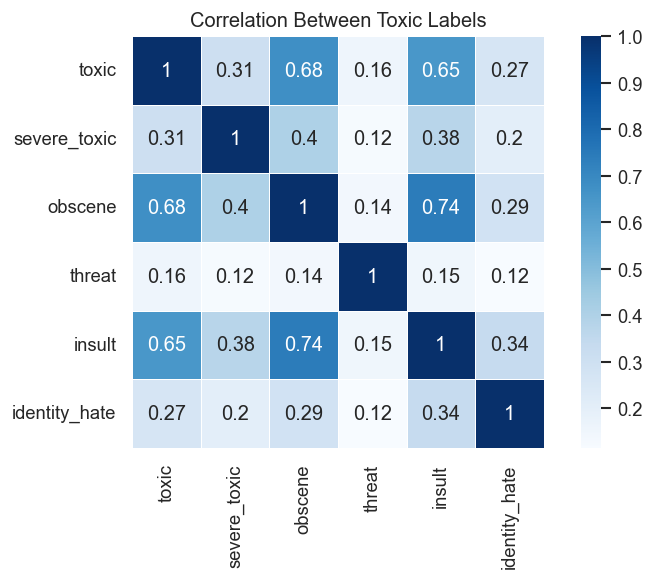

In [5]:
# 2. Label Distribution & Class Balance Analysis — VISUAL VERSION

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams["figure.dpi"] = 120

label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# ---------- A. Label Counts Barplot ----------
label_counts = df[label_cols].sum().sort_values(ascending=False)

plt.figure(figsize=(7, 4))
sns.barplot(
    x=label_counts.index,
    y=label_counts.values
)
plt.title("Label Distribution Across Toxic Categories")
plt.xlabel("Category")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# ---------- B. Toxic vs Non-Toxic Pie Chart ----------
non_toxic = (df[label_cols].sum(axis=1) == 0).sum()
toxic = df.shape[0] - non_toxic

plt.figure(figsize=(5, 5))
plt.pie(
    [non_toxic, toxic],
    labels=['Non-Toxic', 'Toxic'],
    autopct='%1.1f%%',
    startangle=90
)
plt.title("Overall Toxic vs Non-Toxic Distribution")
plt.tight_layout()
plt.show()

# ---------- C. Heatmap of Label Co-occurrence ----------
co_matrix = df[label_cols].corr()

plt.figure(figsize=(7, 5))
sns.heatmap(
    co_matrix,
    annot=True,
    cmap="Blues",
    linewidths=0.5,
    square=True
)
plt.title("Correlation Between Toxic Labels")
plt.tight_layout()
plt.show()


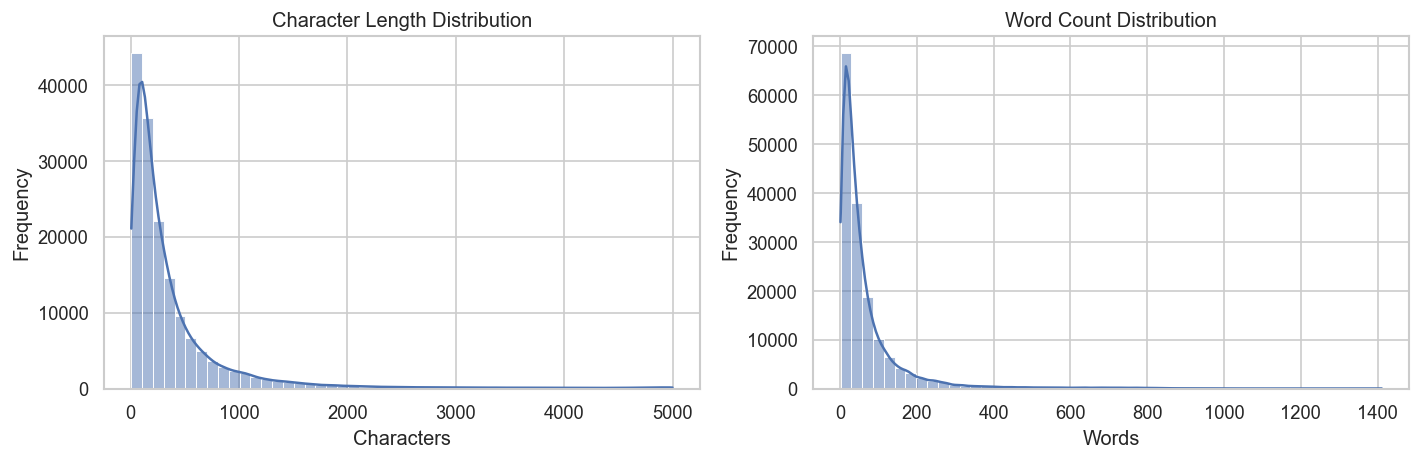

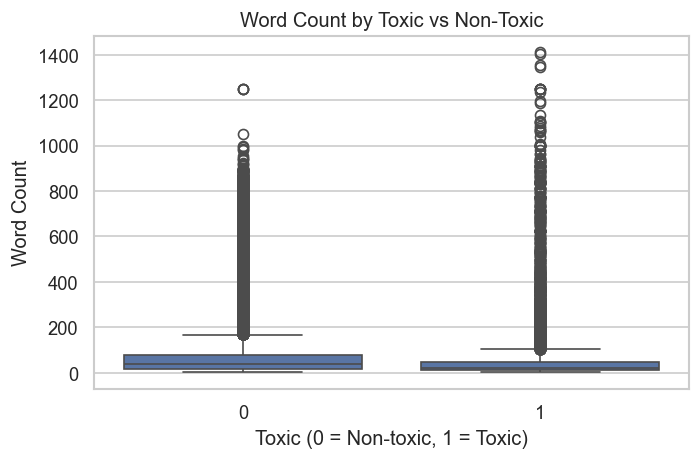

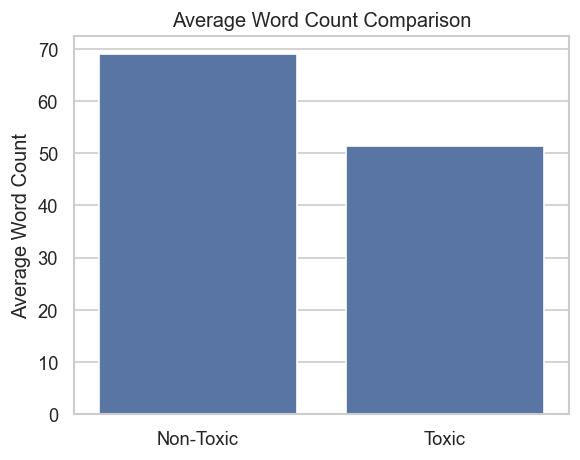

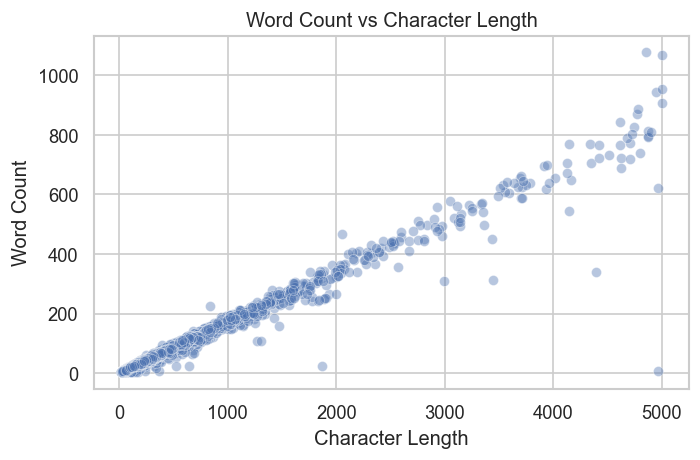

In [6]:
# 3. Comment Length & Text Analysis — VISUAL VERSION

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams["figure.dpi"] = 120

# ========== A. Length Features ==========
df["char_length"] = df["comment_text"].apply(len)
df["word_count"] = df["comment_text"].apply(lambda x: len(str(x).split()))

# ========== B. Histograms for Character & Word Length ==========
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(df["char_length"], bins=50, kde=True, ax=ax[0])
ax[0].set_title("Character Length Distribution")
ax[0].set_xlabel("Characters")
ax[0].set_ylabel("Frequency")

sns.histplot(df["word_count"], bins=50, kde=True, ax=ax[1])
ax[1].set_title("Word Count Distribution")
ax[1].set_xlabel("Words")
ax[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

# ========== C. Boxplots: Toxic vs Non-Toxic ==========
plt.figure(figsize=(6, 4))
sns.boxplot(
    data=df,
    x="toxic",
    y="word_count"
)
plt.title("Word Count by Toxic vs Non-Toxic")
plt.xlabel("Toxic (0 = Non-toxic, 1 = Toxic)")
plt.ylabel("Word Count")
plt.tight_layout()
plt.show()

# ========== D. Average Word Count Barplot ==========
avg_len_toxic = df[df["toxic"] == 1]["word_count"].mean()
avg_len_nontoxic = df[df["toxic"] == 0]["word_count"].mean()

plt.figure(figsize=(5, 4))
sns.barplot(
    x=["Non-Toxic", "Toxic"],
    y=[avg_len_nontoxic, avg_len_toxic]
)
plt.title("Average Word Count Comparison")
plt.ylabel("Average Word Count")
plt.tight_layout()
plt.show()

# ========== E. Scatterplot: Word Count vs Character Length ==========
plt.figure(figsize=(6, 4))
sns.scatterplot(
    data=df.sample(min(5000, len(df))),  # reduce clutter
    x="char_length",
    y="word_count",
    alpha=0.4
)
plt.title("Word Count vs Character Length")
plt.xlabel("Character Length")
plt.ylabel("Word Count")
plt.tight_layout()
plt.show()


In [9]:
# 4. Word-Level Exploration — VISUAL VERSION

from collections import Counter
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

sns.set(style="whitegrid")
plt.rcParams["figure.dpi"] = 120

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    return text

# Clean text
df['clean_text'] = df['comment_text'].apply(clean_text)

# Toxic / Non-toxic corpora
toxic_texts = " ".join(df[df["toxic"] == 1]["clean_text"])
nontoxic_texts = " ".join(df[df["toxic"] == 0]["clean_text"])

# Word frequencies
toxic_words = Counter(toxic_texts.split()).most_common(20)
nontoxic_words = Counter(nontoxic_texts.split()).most_common(20)


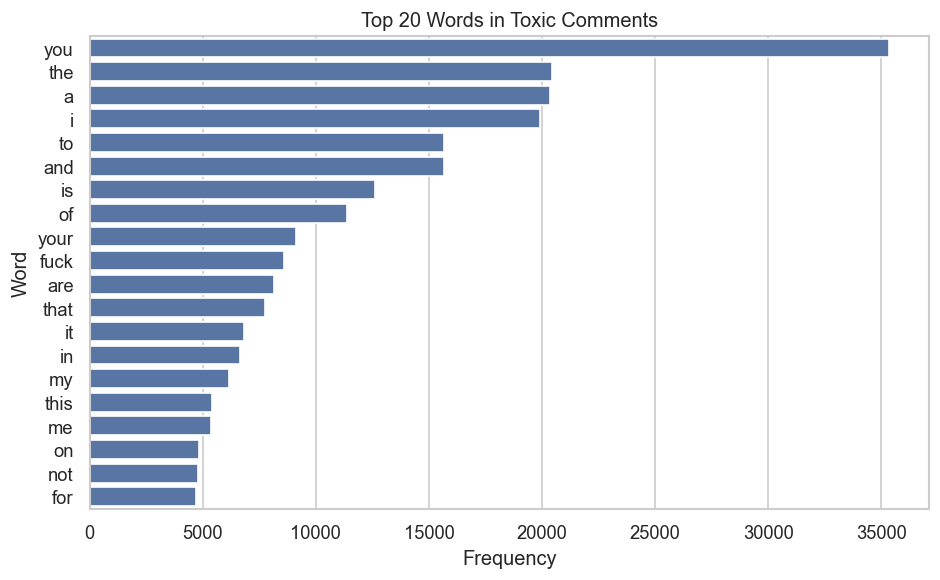

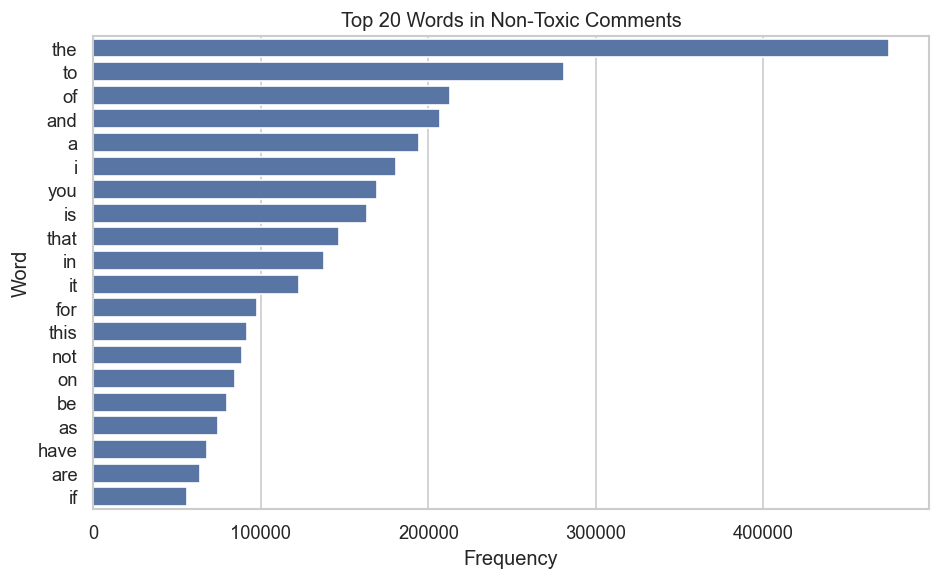

In [10]:
# Convert to DataFrames for easy plotting
toxic_df = pd.DataFrame(toxic_words, columns=["word", "count"])
nontoxic_df = pd.DataFrame(nontoxic_words, columns=["word", "count"])

# Toxic words barplot
plt.figure(figsize=(8, 5))
sns.barplot(data=toxic_df, y="word", x="count")
plt.title("Top 20 Words in Toxic Comments")
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.tight_layout()
plt.show()

# Non-toxic words barplot
plt.figure(figsize=(8, 5))
sns.barplot(data=nontoxic_df, y="word", x="count")
plt.title("Top 20 Words in Non-Toxic Comments")
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.tight_layout()
plt.show()


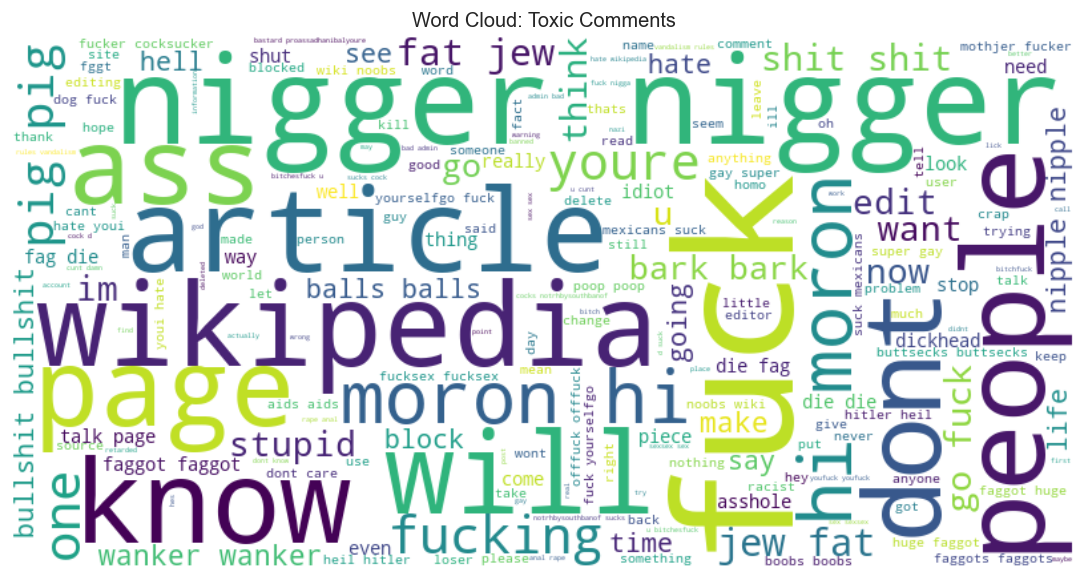

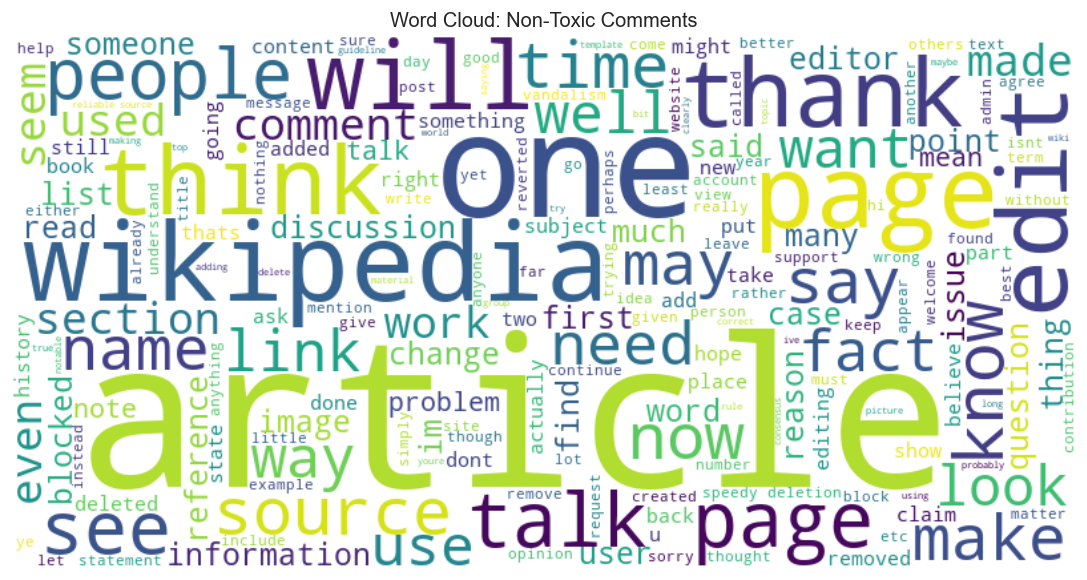

In [11]:
# Toxic word cloud
wc_toxic = WordCloud(width=800, height=400, background_color='white').generate(toxic_texts)

plt.figure(figsize=(10, 5))
plt.imshow(wc_toxic, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud: Toxic Comments")
plt.tight_layout()
plt.show()

# Non-toxic word cloud
wc_nontoxic = WordCloud(width=800, height=400, background_color='white').generate(nontoxic_texts)

plt.figure(figsize=(10, 5))
plt.imshow(wc_nontoxic, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud: Non-Toxic Comments")
plt.tight_layout()
plt.show()


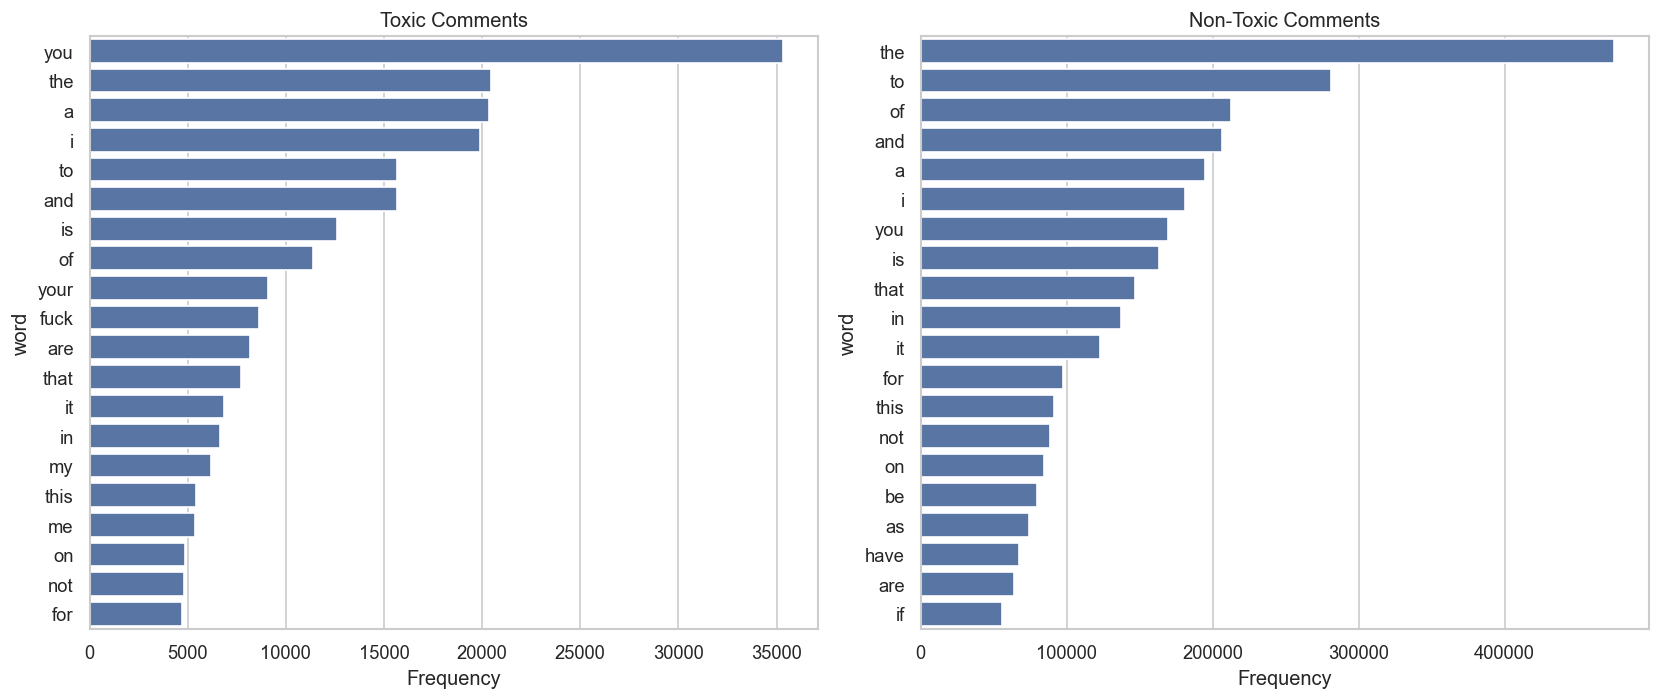

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.barplot(data=toxic_df, y="word", x="count", ax=axes[0])
axes[0].set_title("Toxic Comments")
axes[0].set_xlabel("Frequency")

sns.barplot(data=nontoxic_df, y="word", x="count", ax=axes[1])
axes[1].set_title("Non-Toxic Comments")
axes[1].set_xlabel("Frequency")

plt.tight_layout()
plt.show()
